In [1]:
import scipy.io
import pickle 
import scipy.ndimage
import numpy as np
from scipy.sparse.linalg import spsolve
from scipy import sparse
import matplotlib.pyplot as plt
from functools import partial

import torch
from Solver import *
# from NeuralNet import *
from timeit import default_timer


import sys
sys.path.append('../Utility')
import NeuralNet
import Numerics
import PlotDefault

# diffusivity is a quadratic function
 $$D(\theta) = \sqrt{\theta^2 + (\frac{\partial \theta}{\partial x})^2}$$

In [2]:
L = 1.0
Ny = 100
yy = np.linspace(0.0, L, Ny)
dy = yy[1] - yy[0]
f = -np.ones_like(yy)
dbc = np.array([0.0, 0.0]) 

GENERATE_DATA = False
if GENERATE_DATA:
    # Training data
    xx, f, q, q_c, dq_c = generate_data()

    # Test data
    def f_func1(xx_test):
        return 6*(1-2*xx_test)**2 - 2*(xx_test - xx_test**2)*(1 - 2*xx_test)**2 + 2*(xx_test - xx_test**2)**2 + 2
    def f_func2(xx_test):
        f = np.ones_like(xx_test)
        f[xx_test <= 0.5] = 0.0
        f[xx_test > 0.5] = 10.0
        return f
    def f_func3(xx_test):
        L = 1
        return 10*np.sin(2*np.pi*xx_test/L)

    f_funcs = [f_func1, f_func2, f_func3]
    xx_test, f_test, q_test, q_c_test, dq_c_test = np.zeros((3, Ny)), np.zeros((3, Ny)), np.zeros((3, Ny)), np.zeros((3, Ny-1)), np.zeros((3, Ny-1))

    for i in range(3):
        f_func = f_funcs[i]
        xx_test[i,:], f_test[i,:], q_test[i,:], q_c_test[i,:], dq_c_test[i,:] = generate_data_helper(permeability_ref, f_func, L=1.0, Nx = 100)
    
    
    data_dict = {'xx': xx, 'f': f, 'q': q, 'xx_test': xx_test, 'f_test': f_test, 'q_test': q_test}
    pickle.dump(data_dict, open("data.pickle", 'wb'))
else:
    data_dict = pickle.load(open("data.pickle",'rb'))   
    xx, f, q = data_dict["xx"], data_dict["f"], data_dict["q"]
    xx_test, f_test, q_test = data_dict["xx_test"], data_dict["f_test"], data_dict["q_test"]


In [3]:
dq = np.copy(q)
ddq = np.copy(q)
for i in range(q.shape[0]):
    dq[i, :]  = Numerics.gradient_first(q[i,:], dy, bc = "one-sided")
    ddq[i, :] = Numerics.gradient_second(q[i,:], dy, bc = "one-sided")
 
dq_test = np.copy(q_test)
ddq_test = np.copy(q_test)
for i in range(q_test.shape[0]):
    dq_test[i, :]  = Numerics.gradient_first(q_test[i,:], dy, bc = "one-sided")
    ddq_test[i, :] = Numerics.gradient_second(q_test[i,:], dy, bc = "one-sided")
  
mu, flux, source = np.copy(q), np.copy(q), np.copy(q)
for i in range(q.shape[0]):
    mu[i,:], flux[i,:], source[i,:] = permeability_ref(np.vstack((q[i,:], dq[i,:])).T), flux_ref(np.vstack((q[i,:], dq[i,:])).T), source_ref_q(q[i,:], dy)
    
mu_test, flux_test, source_test = np.copy(q_test), np.copy(q_test), np.copy(q_test)
for i in range(q_test.shape[0]):
    mu_test[i,:], flux_test[i,:], source_test[i,:] = permeability_ref(np.vstack((q_test[i,:], dq_test[i,:])).T), flux_ref(np.vstack((q_test[i,:], dq_test[i,:])).T), source_ref_q(q_test[i,:], dy)


In [4]:
import itertools

# polynomial orders in nps, nps[0] = 0
def generate_feature(nps, *arg):
    assert(nps[0] == 0)
    
    nf = len(arg)
    nd = len(arg[0])
    
    # generate powers
    powers = list(itertools.product(nps, repeat=nf))
    
    dic = []
    for indp in range(len(powers)):
        cpower = powers[indp]
        if all(p == 0 for p in cpower):
            continue
            
        feature = np.ones(nd)
        for i in range(nf):
            feature *= arg[i]**cpower[i]
        dic.append(feature)
    
    
    return np.vstack(dic).T

nps = [0,1,2,3]

In [71]:
for nn_save_name in ["diffusivity.dic", "flux.dic", "source.dic"]:

    print("start train nn : ", nn_save_name)
    if nn_save_name == "diffusivity.dic":
        x_train = generate_feature(nps, q.flatten(), dq.flatten())
        y_train = mu.flatten()[:,np.newaxis]

    elif nn_save_name == "flux.dic":
        x_train = generate_feature(nps, q.flatten(), dq.flatten())
        y_train = flux.flatten()[:,np.newaxis]
        
    elif nn_save_name == "source.dic":
        x_train = generate_feature(nps, q.flatten(), dq.flatten(), ddq.flatten())
        y_train = source.flatten()[:,np.newaxis]
    else:
        print("nn_save_name : ", nn_save_name, " is not recognized")

    
    x_train = torch.from_numpy(x_train.astype(np.float32))
    y_train = torch.from_numpy(y_train.astype(np.float32))

    ind = x_train.shape[1]
    outd = y_train.shape[1] 

    learning_rate = 0.001
    step_size = 100
    gamma = 0.5  
    epochs = 5000
    batch_size = 64

    net = NeuralNet.FNN(ind, outd, 1, width, activation, initializer, outputlayer) 
    train_loader = torch.utils.data.DataLoader(torch.utils.data.TensorDataset(x_train, y_train), batch_size=batch_size, shuffle=True)
    optimizer = NeuralNet.Adam(net.parameters(), lr=learning_rate, weight_decay=1e-4)
    scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=step_size, gamma=gamma)

    myloss = torch.nn.MSELoss(reduction='sum')
    t0 = default_timer()
    for ep in range(epochs):
        net.train()
        t1 = default_timer()
        train_l2 = 0
        for x, y in train_loader:

            optimizer.zero_grad()
            out = net(x)

            loss = myloss(out , y)*100
            loss.backward()

            optimizer.step()
            train_l2 += loss.item()


        if ep % 1000 == 0:
            # train_l2/= ntrain
            t2 = default_timer()
            print("Epoch : ", ep, " Epoch time : ", t2-t1, " Train L2 Loss : ", train_l2)
            if nn_save_name is not None:
                torch.save(net, nn_save_name)



start train nn :  diffusivity.dic
Epoch :  0  Epoch time :  0.025047210976481438  Train L2 Loss :  86684.14846801758
Epoch :  1000  Epoch time :  0.012241829186677933  Train L2 Loss :  225.38669443130493
Epoch :  2000  Epoch time :  0.012077219784259796  Train L2 Loss :  223.04863047599792
Epoch :  3000  Epoch time :  0.012087887153029442  Train L2 Loss :  222.2545461654663
Epoch :  4000  Epoch time :  0.012057637795805931  Train L2 Loss :  221.51620322465897
start train nn :  flux.dic
Epoch :  0  Epoch time :  0.012197569943964481  Train L2 Loss :  64482.42021179199
Epoch :  1000  Epoch time :  0.012135251425206661  Train L2 Loss :  100.65868085622787
Epoch :  2000  Epoch time :  0.012349429540336132  Train L2 Loss :  100.52775150537491
Epoch :  3000  Epoch time :  0.01207674015313387  Train L2 Loss :  100.35974046681076
Epoch :  4000  Epoch time :  0.012148397043347359  Train L2 Loss :  99.59967495501041
start train nn :  source.dic
Epoch :  0  Epoch time :  0.015049011446535587  Tra

In [5]:
nn_save_name = "flux.dic"
trained_net = torch.load(nn_save_name)


# print(trained_net.modus['LinM{}'.format(1)].weight)
# print(trained_net.modus['LinM{}'.format(1)].bias)
print(trained_net.modus['LinMout'].weight)
print(trained_net.modus['LinMout'].bias)

Parameter containing:
tensor([[ 0.5287,  0.0713,  0.4467,  0.3351, -0.4892, -0.1503,  0.3322, -0.5455,
          0.7319, -0.1792,  0.2179,  0.2188,  0.5490,  0.4706,  0.3075]],
       requires_grad=True)
Parameter containing:
tensor([-0.0627], requires_grad=True)


/tmp/ipykernel_185366/3578385685.py:50: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  im0=ax[0].pcolormesh(X_test_2d, Y_test_2d, y_test_2d, vmin=vmin, vmax=vmax)
/tmp/ipykernel_185366/3578385685.py:54: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  im1=ax[1].pcolormesh(X_test_2d, Y_test_2d, y_pred_2d, vmin=vmin, vmax=vmax)
/tmp/ipykernel_185366/3578385685.py:58: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is depreca

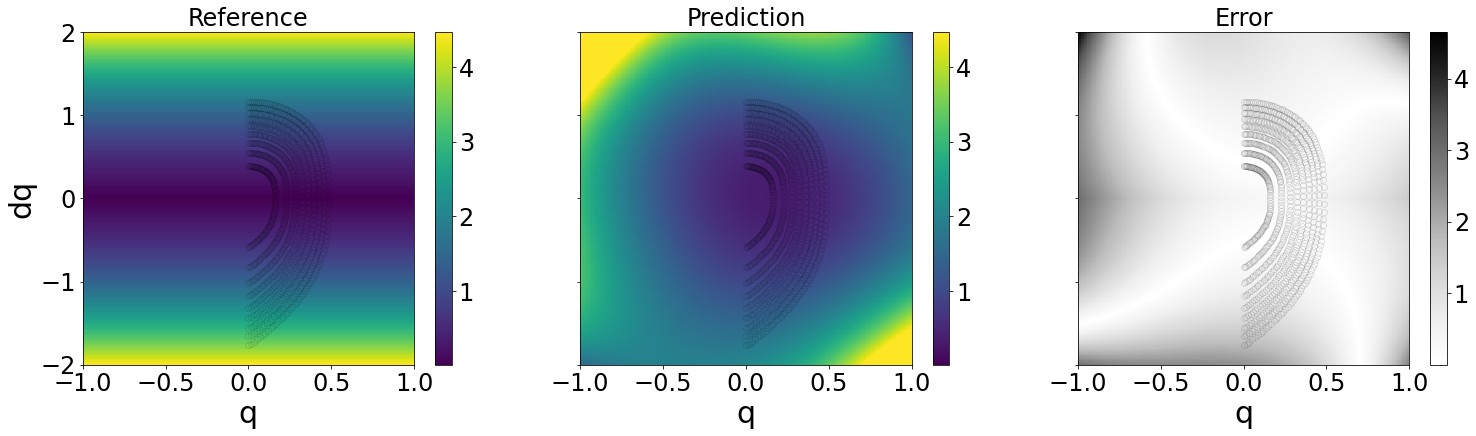

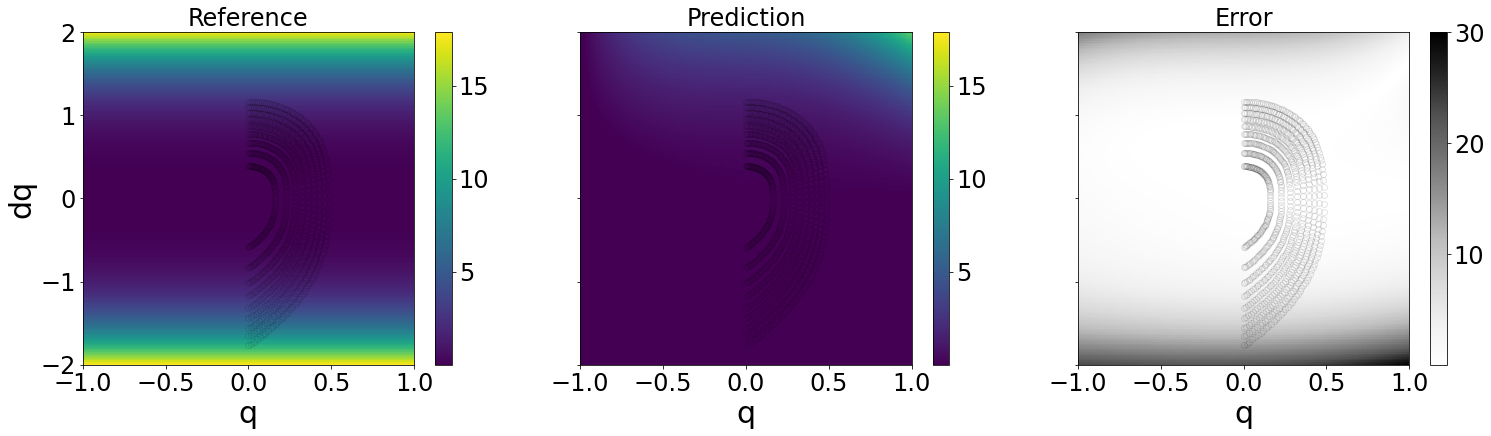

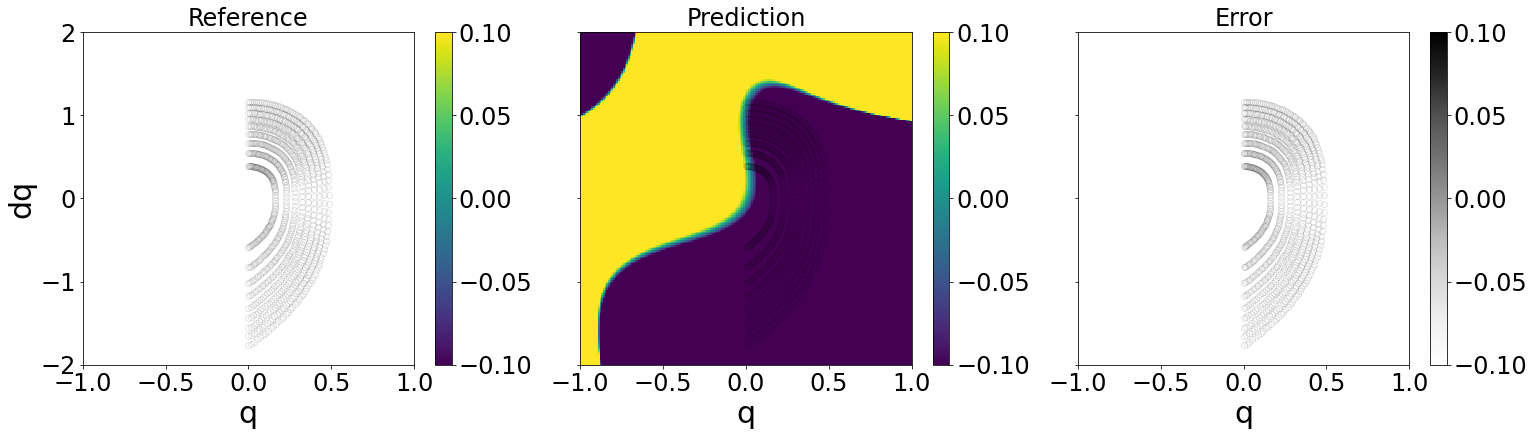

In [89]:
N_test_1d = 200
Lx_test_1d = 1.0
Ly_test_1d = 2.0
N_test = N_test_1d**2

x1_test_1d = np.linspace(-Lx_test_1d, Lx_test_1d, N_test_1d)
x2_test_1d = np.linspace(-Ly_test_1d, Ly_test_1d, N_test_1d)
X_test_2d, Y_test_2d = np.meshgrid(x1_test_1d, x2_test_1d)
Z_test_2d = np.zeros(N_test)

for nn_save_name in ["diffusivity.dic", "flux.dic", "source.dic"]:
    if nn_save_name  == "diffusivity.dic":
        x_test =  generate_feature(nps, X_test_2d.reshape(-1), Y_test_2d.reshape(-1))      
        y_test = permeability_ref(x_test).reshape((N_test, 1))
        trained_net = torch.load(nn_save_name)
        scale = mu_scale
    elif nn_save_name  == "flux.dic":
        x_test = generate_feature(nps, X_test_2d.reshape(-1), Y_test_2d.reshape(-1))     
        y_test = flux_ref(x_test).reshape((N_test, 1))
        trained_net = torch.load(nn_save_name)
        scale = flux_scale
    elif nn_save_name  == "source.dic":
        x_test = generate_feature(nps, X_test_2d.reshape(-1), Y_test_2d.reshape(-1), Z_test_2d)
        y_test = source_ref(x_test).reshape((N_test, 1))
        trained_net = torch.load(nn_save_name)
        scale = source_scale
    else:
        print("nn_save_name : ", nn_save_name, " is not recognized")
        



    y_pred = NeuralNet.net_eval(net=trained_net, x=x_test, mu_scale=scale, non_negative=False, filter_on=False, filter_sigma=filter_sigma, n_data=N_test_1d)  

    y_test_2d = y_test.reshape((N_test_1d,N_test_1d))
    y_pred_2d = y_pred.reshape((N_test_1d,N_test_1d))


    fig, ax = plt.subplots(ncols=3, sharey=True, nrows=1, figsize=((22,6)))

    for j in range(3):
        for i in range(q.shape[0]):
            ax[j].plot(q[i, :], dq[i, :],  "o", color = "black", fillstyle="none", alpha=0.1)
            ax[j].set_xlabel("q")
            if j == 0:
                ax[j].set_ylabel("dq")


    vmin, vmax = y_test_2d.min(), y_test_2d.max()
    im0=ax[0].pcolormesh(X_test_2d, Y_test_2d, y_test_2d, vmin=vmin, vmax=vmax)
    fig.colorbar(im0, ax=ax[0])
    ax[0].set_title("Reference")

    im1=ax[1].pcolormesh(X_test_2d, Y_test_2d, y_pred_2d, vmin=vmin, vmax=vmax)
    fig.colorbar(im1, ax=ax[1])
    ax[1].set_title("Prediction")

    im2=ax[2].pcolormesh(X_test_2d, Y_test_2d, np.abs(y_test_2d - y_pred_2d), cmap = "Greys")
    fig.colorbar(im2, ax=ax[2])
    ax[2].set_title("Error")



    fig.subplots_adjust(bottom=0.15,top=0.92,left=0.08,right=0.97)



In [90]:
def nummodel(permeability, q, yy, res):
    
    Ny = yy.size
    dy = yy[1] - yy[0]
    dq_c = gradient_first_f2c(q, dy)
    q_c = interpolate_f2c(q)
    x = generate_feature(nps, q_c, dq_c)
    mu_c = permeability(x = x)
    res[:] = gradient_first_c2f(mu_c*(dq_c), dy)

# dM/dx    
def nummodel_flux(flux, q, yy, res):
    
    Ny = yy.size
    dy = yy[1] - yy[0]
    dq_c = gradient_first_f2c(q, dy)
    q_c = interpolate_f2c(q)
    x = generate_feature(nps, q_c, dq_c)
    M_c = flux(x = x)
    res[:] = gradient_first_c2f(M_c, dy)

    
def nummodel_source(source, q, yy, res):
    
    Ny = yy.size
    dy = yy[1] - yy[0]
    dq = gradient_first(q, dy)
    ddq = gradient_first(dq, dy)
    x = generate_feature(nps, q, dq, ddq)
    S_f = source(x = x)
    res[:] = S_f[1:-1]

100000 max q nan
200000 max q nan
300000 max q nan
400000 max q nan
500000 max q nan
100000 max q nan
200000 max q nan
300000 max q nan
400000 max q nan
500000 max q nan
100000 max q nan
200000 max q nan
300000 max q nan
400000 max q nan
500000 max q nan
100000 max q 0.38550489557706563
200000 max q 0.3855378792928736
300000 max q 0.3855378800149575
400000 max q 0.38553788001602735
500000 max q 0.385537880015175
100000 max q 0.5146429453995437
200000 max q 0.5146446699343352
300000 max q 0.5146446699348881
400000 max q 0.5146446703467668
500000 max q 0.5146446703523819
100000 max q 0.2366348579564681
200000 max q 0.23663432763522532
300000 max q 0.23663432735176856
400000 max q 0.23663432735235748
500000 max q 0.23663432735130832
100000 max q 0.38462180959619446
200000 max q 0.38470737168655184
300000 max q 0.38470737859230014
400000 max q 0.38470737859558735
500000 max q 0.38470737860126136
100000 max q 0.5159208644667905
200000 max q 0.5159254711377537
300000 max q 0.5159254711226202

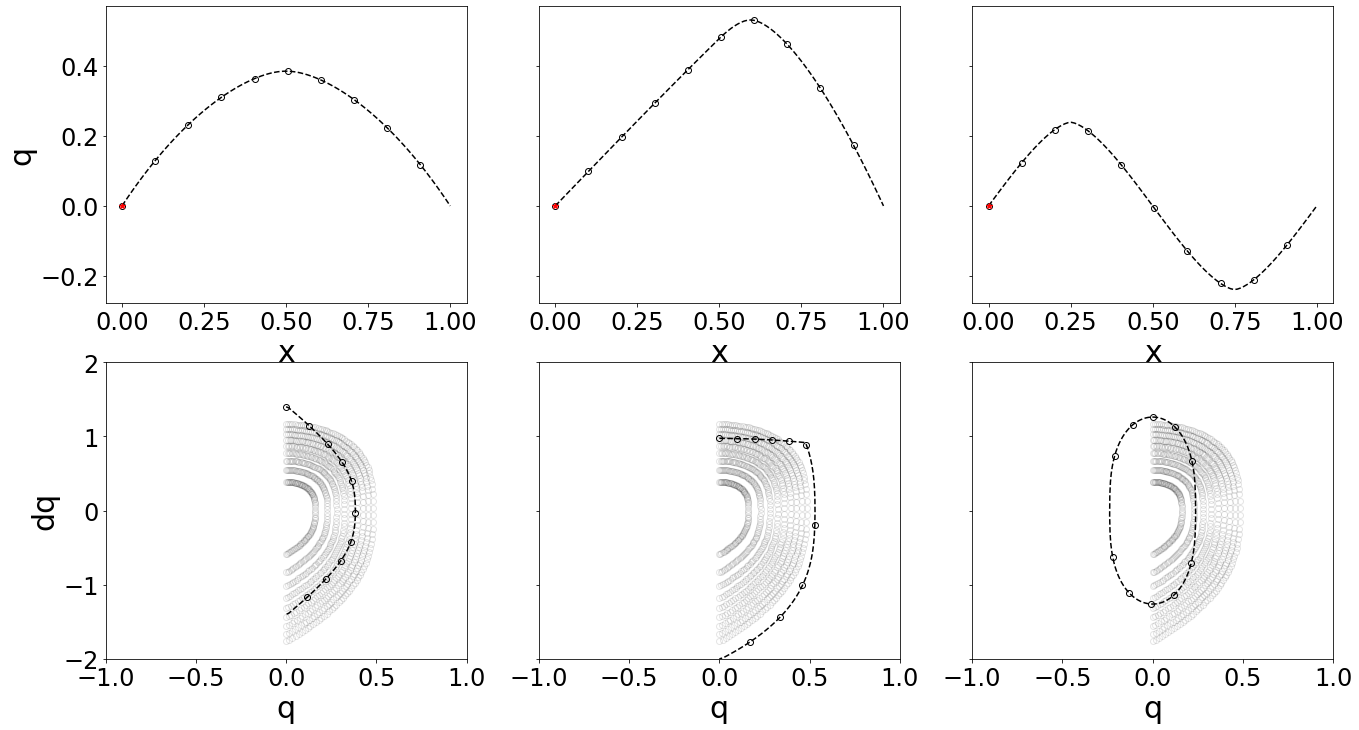

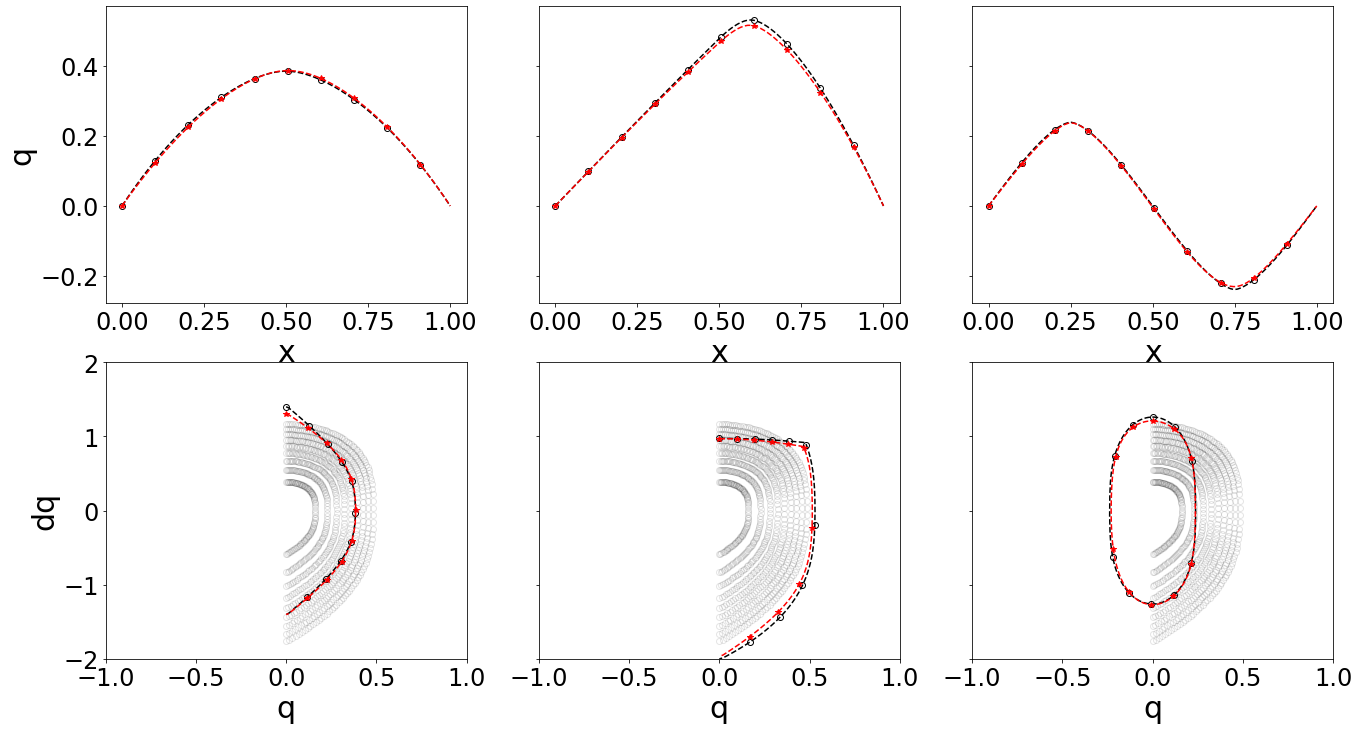

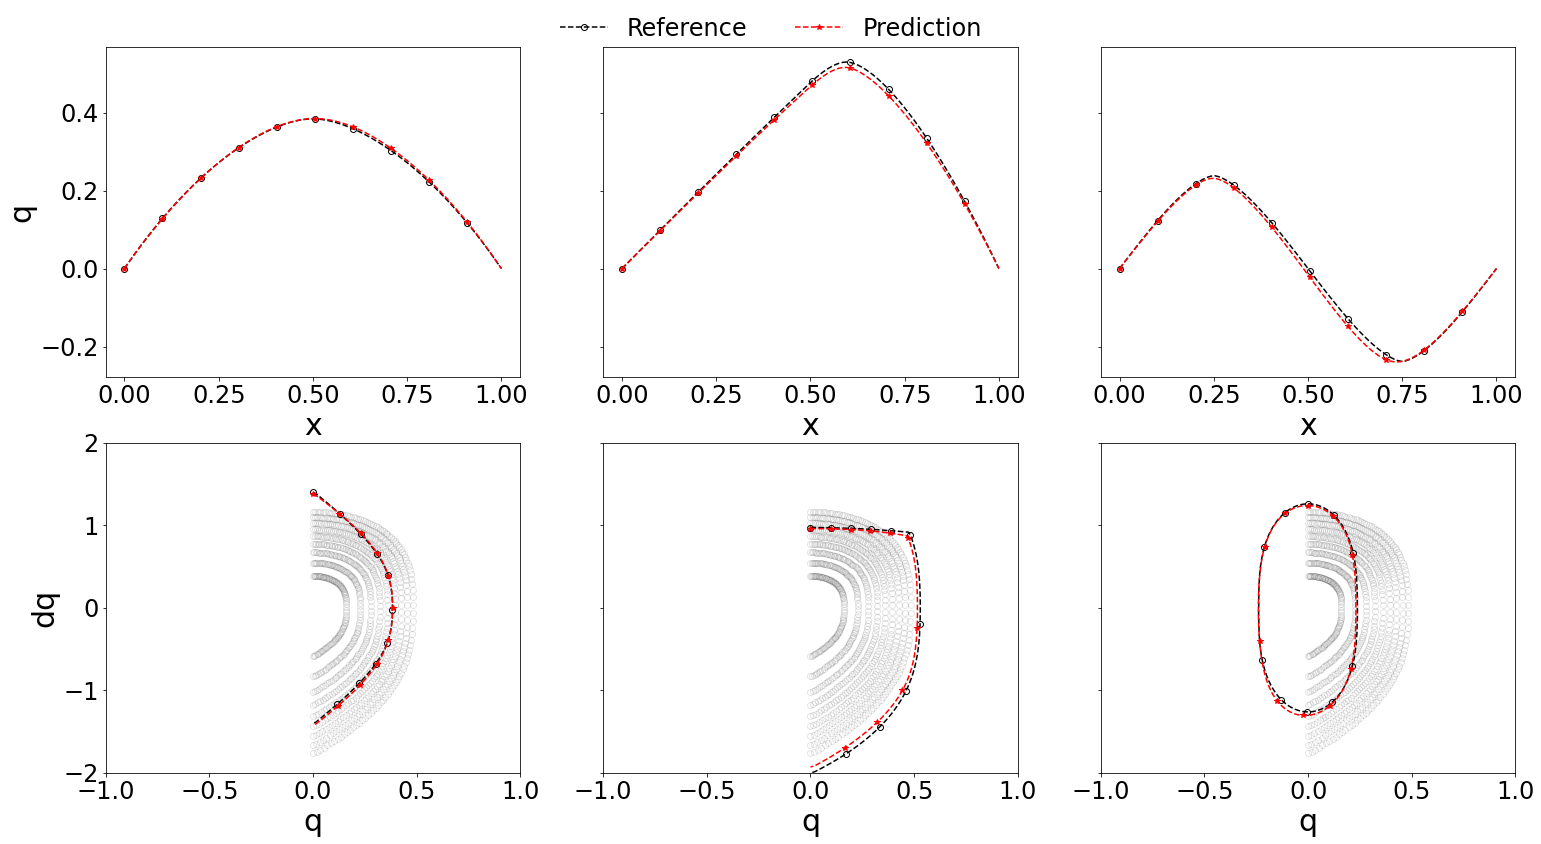

In [91]:
L, Nx =1.0, 100
xx = np.linspace(0.0, L, Nx)
dx = xx[1] - xx[0]
dbc = np.array([0.0, 0.0])  
def f_func1(xx_test):
    return 6*(1-2*xx_test)**2 - 2*(xx_test - xx_test**2)*(1 - 2*xx_test)**2 + 2*(xx_test - xx_test**2)**2 + 2

def f_func2(xx_test):
    f = np.ones_like(xx_test)
    f[xx_test <= 0.5] = 0.0
    f[xx_test > 0.5] = 10.0
    return f

def f_func3(xx_test):
    L = 1
    return 10*np.sin(2*np.pi*xx_test/L)

f_funcs = [f_func1, f_func2, f_func3]


for nn_save_name in ["source.dic", "diffusivity.dic", "flux.dic"]:
    trained_net = torch.load(nn_save_name)



    fig, ax = plt.subplots(ncols=3, nrows=2, sharey="row", figsize=((22,12)))

    for i in range(3):

        f_func = f_funcs[i]
        f = f_func(xx)   
        filter_on = False
        if nn_save_name  == "diffusivity.dic":
            nn_model = partial(NeuralNet.nn_viscosity, net=trained_net, mu_scale = mu_scale, non_negative=True, filter_on=filter_on, filter_sigma=filter_sigma)
            model = lambda q, yy, res : nummodel(nn_model, q, yy, res)
        elif nn_save_name  == "flux.dic":
            nn_model = partial(NeuralNet.nn_viscosity, net=trained_net, mu_scale = flux_scale, non_negative=False, filter_on=filter_on, filter_sigma=filter_sigma)
            model = lambda q, yy, res : nummodel_flux(nn_model, q, yy, res)
        elif nn_save_name  == "source.dic":
            nn_model = partial(NeuralNet.nn_viscosity, net=trained_net, mu_scale = source_scale, non_negative=False, filter_on=filter_on, filter_sigma=filter_sigma)
            model = lambda q, yy, res : nummodel_source(nn_model, q, yy, res)
        else:
            print("nn_save_name : ", nn_save_name, " is not recognized")
            
            
            
        _, _, q_data = explicit_solve(model, f, dbc, dt = 5.0e-6, Nt = 500000, save_every = 100000, L = L)
        q_pred = q_data[-1, :]
        dq_pred  = Numerics.gradient_first(q_pred, dy, bc = "one-sided")


        ax[0,i].plot(xx_test[i,:], q_test[i,:],  "--o", color="black", fillstyle="none", label="Reference", markevery=10)
        ax[0,i].plot(xx_test[i,:], q_pred,  "--*", color="red", label="Prediction", markevery=10)
        if i == 0:
            ax[0,i].set_ylabel("q")
        ax[0,i].set_xlabel("x")

        for j in range(q.shape[0]):
            ax[1,i].plot(q[j, :], dq[j, :],  "o", color = "black", fillstyle="none", alpha=0.1)

        ax[1,i].plot(q_test[i,:], dq_test[i,:],  "--o", color="black", fillstyle="none", label="Reference", markevery=10)
        ax[1,i].plot(q_pred, dq_pred,  "--*", color="red", label="Prediction", markevery=10)
        ax[1,i].set_xlim([-1,1])
        ax[1,i].set_ylim([-2,2])
        if i == 0:
            ax[1,i].set_ylabel("dq")
        ax[1,i].set_xlabel("q")


    
    

    
handles, labels = ax[0,0].get_legend_handles_labels()
fig.subplots_adjust(bottom=0.08,top=0.92,left=0.08,right=0.97)
fig.legend(handles,labels,loc = "upper center",bbox_to_anchor=(0.5,0.98),ncol=2,frameon=False)

